# zeus: Sampling from multimodal distributions

Copied from the zeus documentation at [https://zeus-mcmc.readthedocs.io/en/latest/index.html](https://zeus-mcmc.readthedocs.io/en/latest/index.html).

In this recipe we will demonstrate how one can use zeus with the Moves interface to sample efficiently from challenging high-dimensional multimodal distributions.

We will start by defining the target distribution, a 50-dimensional mixture of Normal distributions with huge valleys of almost-zero probability between the modes.
This is an extremelly difficult target to sample from and most methods would fail.

In [1]:
import zeus 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# Number of dimensions
ndim = 50

# Means
mu1 = np.ones(ndim) * (1.0 / 2)
mu2 = -mu1

# Standard Deviations
stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(ndim)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.33  # one mode with 0.1 of the mass
w2 = 1 - w1 # the other mode with 0.9 of the mass

# Uniform prior limits
low = -2.0
high = 2.0

# The log-likelihood function of the Gaussian Mixture
def two_gaussians(x):
    log_like1 = (
        -0.5 * ndim * np.log(2 * np.pi)
        - 0.5 * np.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    log_like2 = (
        -0.5 * ndim * np.log(2 * np.pi)
        - 0.5 * np.log(dsigma)
        - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    )
    return np.logaddexp.reduce([np.log(w1) + log_like1, np.log(w2) + log_like2])

# A simple uniform log-prior
def log_prior(x):
    if np.all(x>low) and np.all(x<high):
        return 0.0
    else:
        return -np.inf

# The Log-Posterior
def log_post(x):
    lp = log_prior(x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + two_gaussians(x)

## A failed attempt

Now lets run ``zeus`` for 1000 steps using 100 walkers and see what happens:

Initialising ensemble of 400 walkers...
Sampling progress : 100%|█████████| 2000/2000 [03:53<00:00,  8.55it/s]


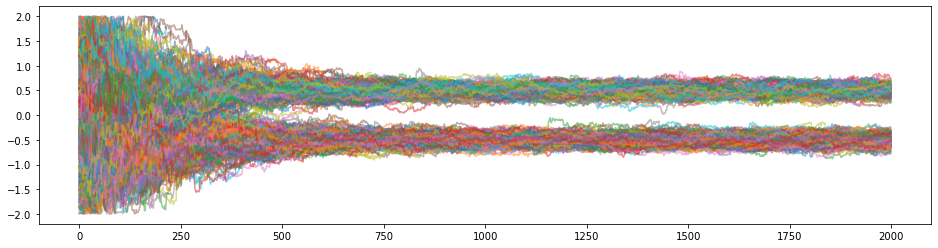

In [2]:
nwalkers = 400
nsteps= 2000

# The starting positions of the walkers
start = low + np.random.rand(nwalkers,ndim) * (high - low)

# Initialise the Ensemble Sampler
sampler = zeus.EnsembleSampler(nwalkers, ndim, log_post)
# Run MCMC
sampler.run_mcmc(start, nsteps)

# Get the samples
samples = sampler.get_chain()

# Plot the walker trajectories for the first parameter of the 10
plt.figure(figsize=(16,4))
plt.plot(samples[:,:,0],alpha=0.5)
plt.show()

As you can see, once the walkers have found the modes/peaks of the Gaussian Mixture they stay stranded there, unable to jump to the other modes.
This is a huge issue because it prevents the walkers from distributing the probability mass fairly among the peaks thus leading to biased results.

## The clever way...

Now that we know that our target is multimodal, and that the default ``DifferentialMove`` cannot facilitate jumps
between modes we can use a more advanced move such as the ``GlobalMove``.

Although the ``GlobalMove`` is a very powerful tools, it is not well suited during the burnin phase.
For that reason we will use the default ``DifferentialMove`` during burnin and then bring out the big guns.

Initialising ensemble of 400 walkers...
Sampling progress : 100%|█████████| 2000/2000 [03:44<00:00,  8.90it/s]
Initialising ensemble of 400 walkers...
Sampling progress : 100%|█████████| 2000/2000 [09:24<00:00,  3.54it/s]


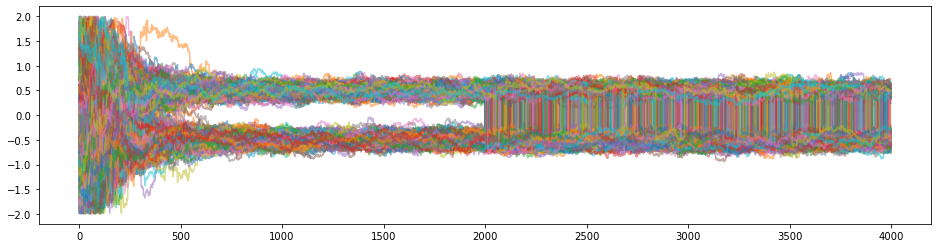

In [3]:
# Initialise the Ensemble Sampler using the default ``DifferentialMove``
sampler = zeus.EnsembleSampler(nwalkers, ndim, log_post)
# Run MCMC
sampler.run_mcmc(start, nsteps)

# Get the burnin samples
burnin = sampler.get_chain()

# Set the new starting positions of walkers based on their last positions
start = burnin[-1]

# Initialise the Ensemble Sampler using the advanced ``GlobalMove``.
sampler = zeus.EnsembleSampler(nwalkers, ndim, log_post, moves=zeus.moves.GlobalMove())
# Run MCMC
sampler.run_mcmc(start, nsteps)

# Get the samples and combine them with the burnin phase for plotting purposes
samples = sampler.get_chain()
total_samples = np.concatenate((burnin, samples))

# Plot the walker trajectories for the first parameter of the 10
plt.figure(figsize=(16,4))
plt.plot(total_samples[:,:,0],alpha=0.5)
plt.show()

You can see that the moment we switched to the ``GlobalMove`` the walkers begun to jump from mode to mode frequently.

Lets now plot the 1D distribution of the first parameter and compare this with "actual truth".

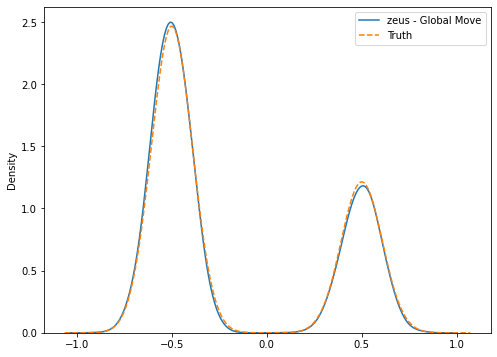

In [4]:
# Compute true samples from the gaussian mixture directly
s1 = np.random.multivariate_normal(mu1, sigma,size=int(w1*200000))
s2 = np.random.multivariate_normal(mu2, sigma,size=int(w2*200000))
samples_true = np.vstack((s1,s2))

# Get the chain from zeus
chain = sampler.get_chain(flat=True, discard=0.5)

# Plot Comparison
plt.figure(figsize=(8,6))
sns.kdeplot(chain[:,0])
sns.kdeplot(samples_true[:,0], ls='--')
plt.legend(['zeus - Global Move', 'Truth']);

Using the advanced moves, the walkers can move great distances in parameter space.